# Lab 9: Stable Diffusion
In this lab, you will have the chance to implement several key parts of a State of the Art (SOTA) model! We will work with the Stable Diffusion model pipeline. Stable Diffusion is a text-to-image generative model--and more: It can also be adapted for image-to-image translation, video generation, unconditioned image generation,...

*   [HuggingFace repository](https://huggingface.co/CompVis/stable-diffusion-v1-4)
*   [GitHub repository](https://github.com/CompVis/stable-diffusion)
*   [Paper on arxiv](https://arxiv.org/abs/2112.10752)

Due to hardware constraints (training this model is very memory intensive), you will not train the model, but will load pretrained weights from the Stable Diffusion repository on [huggingface.co](huggingface.co). Then, you can run inference with the pipeline and generate some awesome images!

The pipeline is comprised of several fairly complex models. The parts you will implement are as follows:

*    The UNet forward function (a UNet like from the cancer detection lab that uses attention like from the transformers lab)
*    DDIM scheduler--the sampling mechanism
*    Loading the pre-trained VAE

Lastly, because the diffusers library is open source, of course it's stipulated that you **not** reference their code for the parts we ask you to implement.

#### Rubric


*   Part 0: Log in to HF (10%)
*   Part 1: Comment what is hapening in the `forward()` function of the UNet with cross attention (20%)
*   Part 2: Implement the DDIM scheduler (40%)
*   Part 3: Load the pretrained models and comment what is happening in the StableDiffusionPipeline (10%)
*   Part 4: Generate an awesome image and answer a few questions (10%)
*   Neat and clean code (10%)



### Part 0: Initial setup and logging in to HuggingFace

If you're not familiar with HuggingFace, it's like a GitHub specifically for deep learning. You can find datasets, models, and more there. We will need it because it has pretrained weights for the models we will use, because training is too memory intensive to manage in Colab.

The repo we will use is ["CompVis/stable-diffusion-v1-4"](https://huggingface.co/CompVis/stable-diffusion-v1-4). To access this repo, you must create a HuggingFace account, then go to this link and accept some terms. You will also need to create a User Access Token. Finally, you can run the cell below, paste the token, and hit login. (It will cache the token so you should only need to do this once per session.) [This tutorial](https://huggingface.co/docs/hub/security-tokens) covers access tokens on HuggingFace.

If the login widget is not working and you are not using Google Chrome, try on Chrome before resorting to other debugging techniques.

In [ ]:
# INSTALLS
%%capture

!pip install diffusers          # Contains the main classes we will be using
!pip install transformers       # Used in pipeline to process text prompt
!pip install huggingface_hub    # For logging in to huggingface 
!pip install ftfy               # For text tokenizing, used by the pipeline
!pip install accelerate         # Helps run in low memory mode -- needed though not explicitly used 

In [ ]:
# GENERIC IMPORTS

import torch
import torch.nn as nn

In [ ]:
# LOG IN TO HUGGINGFACE

from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Part 1: UNet with attention

Stable Diffusion uses a UNet as part of its training and inference pipeline. You might not be familiar with the term pipeline as used here--it just means a singular object that will create the needed submodels, and when called, it coordinates calling each submodel, so that there's just one object that will take in a text prompt and output a photo result. This way, the user just interacts with one object, rather than having to instantiate several objects and coordinate them.

What does this pipeline do? In Stable Diffusion there are quite a few moving parts. The flow from the text prompt to the final images is:

1.   Tokenize the text (with some tokenizer)
2.   Encode the text (with a pretrained NLP model like a transformer)
3.   Generate initial latent space representation of the generated image (this will be pure noise at the beginning)
4. Process the latent space representation with a UNet that has been trained to predict what noise was added to its input in the latest timestep. The UNet attends to the encoded text as it does so, making it conditioned via attention.
5.   Subtract the noise prediction from $x_t$ to get the prediction for $x_{t-1}$.
6.   Repeat steps 4 and 5 many times.
7.   Take the final latent space representation of the generated image and decode it to pixel space (using something like a VAE).
8.   Run through a "SafetyChecker" to make sure there is no NSFW content; if there is, return a black image instead and raise a flag.

In this lab, we subclass from classes defined in the actual Stable Diffusion source code; this gives us several auxiliary functions that are somewhat unenlightening to implement, like loading the pretrained weights from huggingface. We will then override the functions that we do want to implement. 

In this part, we will override the forward function of the UNet so you have a chance to implement it. Follow the comments throughout, or it could be difficult.

This part gives a good example of how attention is used in SOTA models. It is used, not only to process the text in the transformer, but also to condition the denoising model on the processed text. Feel free to look at the source code for the UNet2DBlocks to see how the attention is calculated. 

Read the following cell, run it, and read the description in the subsequent cell:

In [ ]:
# DESCRIBE UNET STRUCTURE TO HELP WITH NEXT CELL

from diffusers.models.unet_2d_condition import *
from diffusers.models.unet_2d_blocks import * 

tmp = UNet2DConditionModel()

print("Items and methods from the UNet2DConditionModel:")
for item in dir(tmp):
  if not item.startswith("__"):
    print(f"{item} is type {type(getattr(tmp, item))}")

del tmp

Items and methods from the UNet2DConditionModel:
T_destination is type <class 'typing.TypeVar'>
_apply is type <class 'method'>
_automatically_saved_args is type <class 'list'>
_backward_hooks is type <class 'collections.OrderedDict'>
_buffers is type <class 'collections.OrderedDict'>
_call_impl is type <class 'method'>
_deprecated_kwargs is type <class 'list'>
_dict_from_json_file is type <class 'method'>
_forward_hooks is type <class 'collections.OrderedDict'>
_forward_pre_hooks is type <class 'collections.OrderedDict'>
_get_backward_hooks is type <class 'method'>
_get_init_keys is type <class 'function'>
_get_name is type <class 'method'>
_internal_dict is type <class 'diffusers.configuration_utils.FrozenDict'>
_is_full_backward_hook is type <class 'NoneType'>
_load_from_state_dict is type <class 'method'>
_load_pretrained_model is type <class 'method'>
_load_state_dict_post_hooks is type <class 'collections.OrderedDict'>
_load_state_dict_pre_hooks is type <class 'collections.Ordere

From the output of the last cell, you should see that the UNet class we are subclassing has a torch.nn.ModuleList called down_blocks, an module called mid_block, and another torch.nn.ModuleList called up_blocks. This should make sense considering you know what the general structure of a UNet is from Lab 4. Each of those blocks is one of the following types:

*   CrossAttnDownBlock2D
*   DownBlock2D
*   CrossAttnUpBlock2D
*   UpBlock2D
*   UNetMidBlock2DCrossAttn

To figure out the data type of a block, use `print(type(block))`. Once you know the data type of the block object, you can do ClassName??, and Colab will bring up a help window for it. Scroll down to see the function source code--this will help you understand how that block is used.

You can also read the [stable diffusion paper](https://arxiv.org/abs/2112.10752) to figure out what is happening in this code.

Add comments at the indicated locations in the code below:

In [ ]:
# DEFINE THE UNET

from diffusers.models.unet_2d_condition import UNet2DConditionModel, UNet2DConditionOutput, Union

class Lab9UNet2DConditionModel(UNet2DConditionModel):
  def forward(
      self,
      sample: torch.FloatTensor,
      timestep: Union[torch.Tensor, float, int],
      encoder_hidden_states: torch.Tensor,
      cross_attention_kwargs,
    ) -> UNet2DConditionOutput:
      """
      Args:
        sample (`torch.FloatTensor`): (batch, channel, height, width) noisy inputs tensor
        timestep (`torch.FloatTensor` or `float` or `int`): (batch) timesteps
        encoder_hidden_states (`torch.FloatTensor`): (batch, channel, height, width) encoder hidden states (the text encoding in our case)

      Returns:
        [`~models.unet_2d_condition.UNet2DConditionOutput`]
      """
      # Make sure sizes match up
      # upsample size should be forwarded when sample is not a multiple of `default_overall_up_factor`
      default_overall_up_factor = 2**self.num_upsamplers
      forward_upsample_size = False
      upsample_size = None
      if any(s % default_overall_up_factor != 0 for s in sample.shape[-2:]):
        forward_upsample_size = True

      # 0. center input if necessary
      if self.config.center_input_sample:
        sample = 2 * sample - 1.0

      # 1. time
      timesteps = timestep
      if not torch.is_tensor(timesteps):
        timesteps = torch.tensor(
          [timesteps], dtype=torch.long, device=sample.device
        )
      elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
        timesteps = timesteps[None].to(sample.device)

      # broadcast to batch dimension and embed using provided projection and embedding for time
      timesteps = timesteps.expand(sample.shape[0])
      t_emb = self.time_proj(timesteps)
      t_emb = t_emb.to(dtype=self.dtype)
      emb = self.time_embedding(t_emb)

      # 2. pre-process
      sample = self.conv_in(sample)

      # 3.
      # YOUR COMMENT HERE
      # Descend down each down block, running sample through each layer
      # This tuple of ResNet samples stores the outputs of each block
      down_block_res_samples = (sample,)
      for downsample_block in self.down_blocks:
        # YOUR COMMENT HERE
        # If the current down block uses attention (it is a CrossAttnDownBlock2D), give it the stored encoder hidden states so it can attend to them
        if (
          hasattr(downsample_block, "attentions")
          and downsample_block.attentions is not None
        ):
          sample, res_samples = downsample_block(
            hidden_states=sample,
            temb=emb,
            encoder_hidden_states=encoder_hidden_states,
          )
        # YOUR COMMENT HERE
        # If the current down block does not use attention (it is a DownBlock2D), don't give it the encoder hidden layers. Just run it as normal
        else:
          sample, res_samples = downsample_block(hidden_states=sample, temb=emb)

        # YOUR COMMENT HERE
        # Concatenate the current down block's output to the total stored tuple of outputs
        down_block_res_samples += res_samples

      # 4.
      # YOUR COMMENT HERE
      # The middle block always uses attention (it is UNetMidBlock2DCrossAttn), so there is no if statement
      # Run the sample through 
      sample = self.mid_block(
        sample, emb, encoder_hidden_states=encoder_hidden_states
      )

      # 5.
      # YOUR COMMENT HERE
      # Ascend through each up block in the model, running the sample through it
      # Give each up block the output from its corresponding down block (in classic U Net style)
      for i, upsample_block in enumerate(self.up_blocks):
        is_final_block = i == len(self.up_blocks) - 1

        res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
        down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

        # if we have not reached the final block and need to forward the
        # upsample size, we do it here
        if not is_final_block and forward_upsample_size:
          upsample_size = down_block_res_samples[-1].shape[2:]

        # YOUR COMMENT HERE
        # If the current up block uses attention (it is a CrossAttnUpBlock2D), give it the stored encoder hidden states AND the corresponding down block outputs (the U in Unet) so it can attend to them
        if (
          hasattr(upsample_block, "attentions")
          and upsample_block.attentions is not None
        ):
          sample = upsample_block(
            hidden_states=sample,
            temb=emb,
            res_hidden_states_tuple=res_samples,
            encoder_hidden_states=encoder_hidden_states,
            upsample_size=upsample_size,
          )
        # YOUR COMMENT HERE
        # If the current up block does not use attention (it is a UpBlock2D), don't give it the encoder hidden layers, but DO give it the corresponding down block output (the U in Unet)
        else:
          sample = upsample_block(
            hidden_states=sample,
            temb=emb,
            res_hidden_states_tuple=res_samples,
            upsample_size=upsample_size,
          )
          
      # 6. post-process
      sample = self.conv_norm_out(sample)
      sample = self.conv_act(sample)
      sample = self.conv_out(sample)

      return UNet2DConditionOutput(sample=sample)

### Part 2: The scheduler

It is the job of a "scheduler" object to add noise to the image in a markovian process while training, and to subtract the UNet's noise prediction from the image (step 5 in the outline of the pipeline from part 1) during inference.

The latest version of the stable diffusion pipeline by default uses a PNDM scheduler, but for we will use the DDIM scheduler as described in the original paper. This will still work well and will align better with what was discussed in lecture.

We subclass the DDIM scheduler from the provided implementation to gain access to the functions that are not of interest to us, but you must override the indicated method with your implementation. The method you will implement is the step method, which intakes the model noise prediction, sample, timestep, and eta, and returns $x_{t-1}$.

The benefit of the DDIM scheduler is that while Stable Diffusion was trained using many timesteps (say 1000) for the forward process, we can do inference with far fewer time steps (say 50). One thing you will have to figure out in this function is what the current timestep is, using the number of training timesteps vs the number of inference timesteps.  (Note that `timestep` and `prev_timestep` are in terms of *training* timesteps, even though in inference timesteps: `prev_timestep_inf = timestep_inf - 1`. You need will to convert between the two because the model was trained in training timesteps and can't correctly interpret inference timesteps without conversion.)

*   [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf)

In [ ]:
# DEFINE THE DDIM SCHEDULER

from diffusers.schedulers import DDIMScheduler
from diffusers.schedulers.scheduling_ddim import DDIMSchedulerOutput
from math import sqrt as sqrt

class Lab9DDIMScheduler(DDIMScheduler):
  def step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        eta: float = 0.0,
  ) -> DDIMSchedulerOutput:
    """
    Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
    process from the learned model outputs (most often the predicted noise).

    Args:
        model_output (`torch.FloatTensor`): direct output from learned diffusion model.
        timestep (`int`): current discrete timestep in the diffusion chain.
        sample (`torch.FloatTensor`):
            current instance of sample being created by diffusion process.
        eta (`float`): weight of noise for added noise in diffusion step.

    Returns:
        [`~schedulers.scheduling_utils.DDIMSchedulerOutput`]
    """
    # Implement formula (12) of DDIM paper https://arxiv.org/pdf/2010.02502.pdf
    # Using formula(16) for sigma.
    # Note that eq. (12) applies to a single reverse diffusion step, but in this
    # function we apply it to a larger diffusion step t - delta_t
    
    # Notation used in this function: <variable name> -> <name in paper>
    # - model_output -> e_theta(t)(x_t)
    # - timestep -> t
    # - sample -> x_t
    # - eta -> eta (eq. 16)
    # - pred_original_sample -> "predicted x_0" in eq. 12
    # - prev_sample -> x_{t-1} in eq. 12

    # Renaming some member variables to be more intuitive and line up with the paper
    num_train_timesteps = self.config.num_train_timesteps
    num_inference_steps = self.num_inference_steps
    alphas = self.alphas_cumprod

    # 1. get previous step value (=t-1)
    # Hint: You can derive the inference time step size (delta_t) from T and tau
    # TODO
    delta_t = num_train_timesteps // num_inference_steps
    prev_timestep = timestep - delta_t
    prev_timestep = 0 if prev_timestep < 0 else prev_timestep
    print("timestep: {} | delta_t: {} | prev_timestep: {}".format(timestep, delta_t, prev_timestep))

    # 2. get alpha_t and alpha_t - 1
    alpha_t = alphas[timestep]
    alpha_t_prev = 0
    if prev_timestep < 0:
      alpha_t_prev = 1
    else:
      alpha_t_prev = alphas[prev_timestep]
    print("alpha_t: {} | alpha_t_prev: {}".format(alpha_t, alpha_t_prev))

    # 3. compute predicted original sample from predicted noise, also called
    # "predicted x_0" of formula (12)
    pred_original_sample = (sample - sqrt(1 - alpha_t)*model_output)/(sqrt(alpha_t))

    # 4. Clip pred_original_sample or "predicted x_0" between -1 and 1
    if self.config.clip_sample:
      pred_original_sample = torch.clamp(pred_original_sample, -1, 1)

    # 5. compute variance: "sigma_t(η)" -> see formula (16)
    # σ_t = eta * sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
    sigma_t = eta * sqrt((1 - alpha_t_prev)/(1 - alpha_t)) * sqrt(1 - alpha_t/alpha_t_prev)

    # 6. compute "direction pointing to x_t" of formula (12)
    pred_sample_direction = sqrt(1 - alpha_t_prev - sigma_t**2) * model_output

    # 7. compute x_t without "random noise" of formula (12)
    prev_sample_wo_noise = sqrt(alpha_t_prev) * pred_original_sample + pred_sample_direction

    # 8. compute x_t with "random noise" added (last term of formula (12))
    noise = sigma_t * torch.randn(sample.shape).cuda()
    prev_sample = prev_sample_wo_noise + noise

    return DDIMSchedulerOutput(
        prev_sample=prev_sample, pred_original_sample=pred_original_sample
    )

### Part 3: Loading pretrained weights and setting up the pipeline

Now, we begin putting the whole pipeline together. 

Other diffusion models like Imagen or DALL-E perform the denoising in pixel space; it was a key contribution of the Stable Diffusion authors to realize it could be done in latent space, significantly reducing the hardware required for Stable Diffusion. Even with this technique, we can't train SD in the memory Colab gives us, but we can at least run inference!

You should load a pretrained VAE from huggingface; this shouldn't be too difficult as we give an example of loading weights from HF right above it. You should also answer the following questions:

1.   Why does Stable Diffusion need a VAE?
2.   What are the dimensions of the latent space of the VAE (i.e. when you encode an image using it)? What are the dimensions of the input image? By what factor is the memory footprint reduced in the latent space compared to pixel space? How does this relate to the performance advantage of Stable Diffusion over pixel-space diffusers like Imagen or DALL-E?

Once you've succeeded in loading these weights, you will pass the UNet, scheduler, and VAE to the pipeline constructor. If you didn't care to override these models, it would instantiate them itself, but here, you should pass them in. **(This means you can test your implementation of one by only passing it in and letting the pipeline instantiate the others from defaults!)**

For this step, write comments describing what is happening at the indicated parts of the code.

In [ ]:
# SET UP PIPELINE

from torch import autocast
from diffusers import StableDiffusionPipeline, AutoencoderKL

# YOUR COMMENT HERE
# The scheduler (defined by me) adds noise at each step and then also subtracts the noise using the predictions of the UNet
scheduler = Lab9DDIMScheduler(
    beta_start=0.00085, # You can mess with these, but they work well
    beta_end=0.012, 
    beta_schedule="scaled_linear"
)

# YOUR COMMENT HERE
# the UNet is trained to predict what noise was added in the previous timestep
unet = Lab9UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="unet",
    use_auth_token=True
)

# YOUR COMMENT HERE
# the Variational Auto Encoder (VAE) compresses the latent space from pixel space so that only the most important features are preserved
# this is a big computational saving compared to some diffusion models, which do the diffusion in many-dimensional pixel space
# 1. Why does Stable Diffusion need a VAE?
#       It not only translates from pixel space to latent space but it compresses the many-dimensional pixel space
#       down to its most important features, saving memory
# 2. What are the dimensions of the latent space of the VAE (i.e. when you encode an image using it)? What 
# are the dimensions of the input image? By what factor is the memory footprint reduced in the latent space
# compared to pixel space? How does this relate to the performance advantage of Stable Diffusion over 
# pixel-space diffusers like Imagen or DALL-E?
#       The values for the dimensions are 3D coming in and 3D returning out
#       The input image is then also 3D. RGB * height * width
#       The scaling factor is .18, meaning the latent space is 1/5 the size of the pixel space
#       The stable diffusion is much faster than Dall-E
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    subfolder="vae", 
    use_auth_token=True
)
print("VAE: in: {} | out: {}".format(vae.in_channels, vae.out_channels))

# YOUR COMMENT HERE
# the pipeline ties all the pieces together, so that I can just hand it one prompt and it encodes the text into latent space, 
# creates random noise, and generates an image matching the description in latent space from the noise
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    unet=unet,
    scheduler=scheduler,
    vae=vae,
    use_auth_token=True
).to("cuda")

VAE: in: 3 | out: 3


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: Lab9DDIMScheduler {
  "_class_name": "Lab9DDIMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config 

### Part 4: Inference

Lastly, come up with a creative prompt (not just using the provided example prompts) and generate an image! If you have enough GPU RAM, you may be able to process several prompts at once. It could be interesting to compare the model's interpretation of several similar prompts, as in the given prompt list, or to add descriptors like "long exposure", "35 mm", or "photorealistic" and see what that changes. 

It could also be interesting to test the limit of the model's understanding of the prompt; if you say, "A blue \<something\> and a red \<something\>", does it ever mix them up? What are the failure modes of this model?

Stable Diffusion was trained using 1000 training timesteps. Using a DDIM scheduler allows us to sample using far fewer. Generate images with various numbers of inference steps (controlled by tau). What values of tau seem to offer the best quality/inference time tradeoff?

Note: If you get a blank image that was identified as "NSFW", it probably is due to the generated image being pure static that can't be identified, and is labeled NSFW just to be safe. This is probably due to an error in the way you implemented the DDIM scheduler.

In [ ]:
# INFERENCE

import gc
print(torch.cuda.memory_allocated() / 1e9)
gc.collect()
print(torch.cuda.memory_allocated() / 1e9)


tau = 20 # TODO
prompt = [
    "watercolor of a heavy metal concert",
    #"oil painting of a woman crying",
    #"a watercolor of a spooky forest",
    #"a watercolor of an enchanted forest",
    #"a watercolor of a mystical forest"
]
  
with autocast("cuda"), torch.inference_mode():
  pipeline_result = pipe(prompt, num_inference_steps=tau) 
                                 # This would be the place to pass in other 
                                 # parameters as desired and as accepted by the function, 
                                 # like the desired height and width, or the guidance scale
                                 # (though we didn't talk about guidance in this lab).

print(torch.cuda.max_memory_allocated()/1e9)
pipeline_result

7.737954304
7.737954304


  0%|          | 0/20 [00:00<?, ?it/s]

timestep: 951 | delta_t: 50 | prev_timestep: 901
alpha_t: 0.00815499946475029 | alpha_t_prev: 0.01400489080697298
timestep: 901 | delta_t: 50 | prev_timestep: 851
alpha_t: 0.01400489080697298 | alpha_t_prev: 0.023076975718140602
timestep: 851 | delta_t: 50 | prev_timestep: 801
alpha_t: 0.023076975718140602 | alpha_t_prev: 0.0365464985370636
timestep: 801 | delta_t: 50 | prev_timestep: 751
alpha_t: 0.0365464985370636 | alpha_t_prev: 0.05571899190545082
timestep: 751 | delta_t: 50 | prev_timestep: 701
alpha_t: 0.05571899190545082 | alpha_t_prev: 0.08191666752099991
timestep: 701 | delta_t: 50 | prev_timestep: 651
alpha_t: 0.08191666752099991 | alpha_t_prev: 0.116324782371521
timestep: 651 | delta_t: 50 | prev_timestep: 601
alpha_t: 0.116324782371521 | alpha_t_prev: 0.15981633961200714
timestep: 601 | delta_t: 50 | prev_timestep: 551
alpha_t: 0.15981633961200714 | alpha_t_prev: 0.2127823829650879
timestep: 551 | delta_t: 50 | prev_timestep: 501
alpha_t: 0.2127823829650879 | alpha_t_prev: 

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F4E66561760>], nsfw_content_detected=[False])

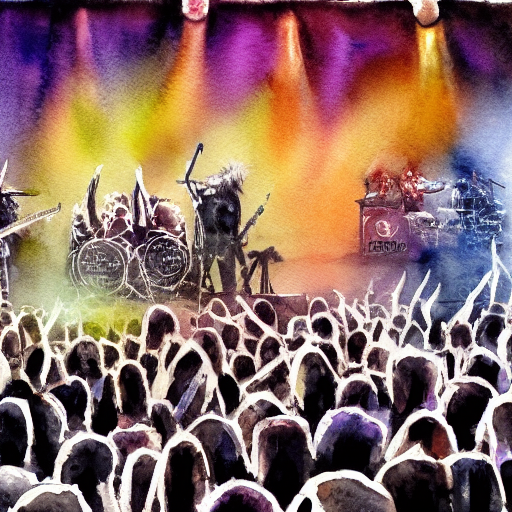

In [ ]:
# DISPLAY IMAGES

for img in pipeline_result["images"]:
  display(img)